In [28]:
%matplotlib inline

import sys
sys.path.append('../src/')

import glob
import warnings

import numpy as np
import pandas as pd
import xarray as xr

from scipy.optimize import curve_fit, minimize

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cmocean import cm
import hvplot.xarray

from sklearn.linear_model import LinearRegression

from epsilon_tools import *
from tools import str2date, avg_funs
import gsw
import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

# set up figure params
sns.set(style='ticks', context='poster', palette='colorblind')
mpl.rc('figure', dpi=100, figsize=[12, 6])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

Infer mixed layer depth under destabilizing condition with buoyancy forcing and wind-stress forcing acting on a stratification profile:
$$
\Delta APE = \int_{z_{ML}}^{0} N^2(z)z dz= \int_{0}^{t} \left[J_b(0)- \frac{\gamma (\mathbf{\tau} \cdot \mathbf{u})}{\rho z_{ML}}\right] dt
$$
Separating buoyancy flux due to heat flux and salt flux:
$$
= \int_{0}^{t} \left[B_Q(0) + B_P(0)- \frac{\gamma (\mathbf{\tau} \cdot \mathbf{u})}{\rho z_{ML}}\right] dt
$$

In [4]:
dat = xr.open_dataset('../data/ml/ww_7781a_1h_2Tf.nc')
met = xr.open_dataset('../data/xarray/qc_ww_7781a.nc')
dat = dat.sel( time = slice('10-5-2016','11-10-2016') )
met = met.sel( mettime = slice('10-5-2016','11-10-2016') )
met = met.sel( time = slice('10-5-2016','11-10-2016') )
emp = xr.open_dataset('../data/CFS/croppped_emp_field.nc')
flot = xr.open_dataset('../data/xarray/qc_7781a.nc')

In [5]:
met['S2'] = np.sqrt(met.dudz**2 + met.dvdz**2)
met['mld_new'] = ('time', met.z.where( met.S2 == met.S2.max(dim='z')).mean(dim='z').rolling(time=6, center=True).mean())
met['S0'] = ('time',met.S.where(met.z>met.mld_new).mean(dim='z'))
met['epz'] = ('time',met.eps.where(met.z>met.mld_new).mean(dim='z'))

In [6]:
cp = gsw.cp_t_exact(flot.isel(z=2).S.mean(),flot.isel(z=2).T.mean(),0)
alphaT = gsw.alpha(flot.isel(z=2).S.mean(),flot.isel(z=2).T.mean(),0)
betaS = gsw.beta(flot.isel(z=2).S.mean(),flot.isel(z=2).T.mean(),0)

In [7]:
rho0=1025
g = 9.81
met['tau'] = 0.5*np.sqrt( met.tx**2 + met.ty**2 )
met['uprime'] = (np.sqrt( met.tau/rho0))**3

met['mld_new'] = ('mettime', met.mld_new.dropna('time').interp(time=met.mettime) )
met['mld'] = ('mettime', met.mld.dropna('time').interp(time=met.mettime) )
met['S0'] = ('mettime', met.S0.dropna('time').interp(time=met.mettime) )
met['epz'] = ('mettime', met.epz.dropna('time').interp(time=met.mettime) )
met['lon'] = ('mettime', met.lon.dropna('time').interp(time=met.mettime) )
met['lat'] = ('mettime', met.lat.dropna('time').interp(time=met.mettime) )

In [8]:
resample = emp.sortby('time').resample(time='1h').mean()
resample = resample.rename({'time':'mettime'})
sub = resample.EMP.interp_like(met) # interpolates onto floats time

In [9]:
collect = []
for t in sub.mettime:
    temp1 = sub.sel(mettime=t)
    temp2 = met.sel(mettime=t)
    
    if ~temp2.lon.isnull() & ~temp2.lat.isnull():
        collect.append(temp1.interp(lon=temp2.lon,lat=temp2.lat))

In [10]:
collect = xr.concat(collect,dim='mettime')
met['emp'] = collect
met['emp'] = met.emp/(100*86400)

In [11]:
met['BQ'] = g*alphaT*met.Qnet/(cp*rho0)
met['BEP'] = g*betaS*met.emp*met.S0/(1-met.S0/1000)
met['B'] = met.BQ + met.BEP
met['MO'] = -met.uprime/(0.4*met.B)
met['MO_MLD'] = met.MO/met.mld_new

In [12]:
gamma = 0.4
met['windforcing'] = met.utau*gamma/rho0/met.mld_new

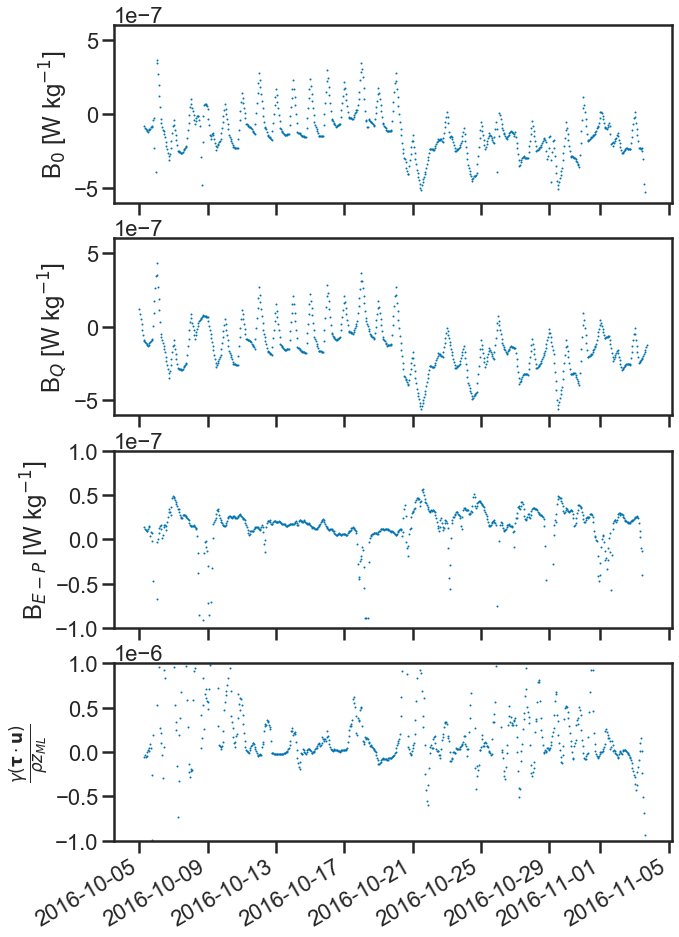

In [13]:
f,ax=plt.subplots(4,1,sharex=True, figsize=(10,15))
# met['uprime'].plot(ax=ax[0],lw=0,marker='.',ms=2)
# ax[0].set_xlabel(None)
# ax[0].set_ylabel(r'u*')
# ax[0].set_ylim(0,2e-6)

met['B'].plot(ax=ax[0],lw=0,marker='.',ms=2)
ax[0].set_xlabel(None)
ax[0].set_ylabel(r'B$_0$ [W kg$^{-1}$]')
ax[0].set_ylim(-6e-7,6e-7)

met['BQ'].plot(ax=ax[1],lw=0,marker='.',ms=2)
ax[1].set_xlabel(None)
ax[1].set_ylabel(r'B$_Q$ [W kg$^{-1}$]')
ax[1].set_ylim(-6e-7,6e-7)

met.BEP.plot(ax=ax[2],lw=0,marker='.',ms=2)
ax[2].set_xlabel(None)
ax[2].set_ylabel(r'B$_{E-P}$ [W kg$^{-1}$]');
ax[2].set_ylim(-1e-7,1e-7);

met.windforcing.plot(ax=ax[3],lw=0,marker='.',ms=2)
ax[3].set_xlabel(None)
ax[3].set_ylabel(r'$\frac{\gamma (\mathbf{\tau} \cdot \mathbf{u})}{\rho z_{ML}}$');
ax[3].set_ylim(-1e-6,1e-6)
ax[3].ticklabel_format(axis='y',style='sci',scilimits=(0,-6))

In [47]:
xr.open_dataset()

<xarray.Dataset>
Dimensions:      (mettime: 888, time: 410, z: 501)
Coordinates:
  * mettime      (mettime) datetime64[ns] 2016-10-05 ... 2016-11-10T23:00:00.000003
  * time         (time) datetime64[ns] 2016-10-05T01:12:07.244664 ... 2016-11-03T17:48:31.978475
  * z            (z) float64 -0.0 -1.985 -3.969 -5.954 ... -986.0 -988.0 -989.9
    pressure     (z) float64 ...
    lat          (mettime) float64 nan nan 40.62 40.62 40.62 ... nan nan nan nan
    lon          (mettime) float64 nan nan 148.5 148.5 148.6 ... nan nan nan nan
Data variables:
    sigma        (z, time) float64 ...
    T            (z, time) float64 ...
    S            (z, time) float64 ...
    n2           (z, time) float64 ...
    rho0         (z, time) float64 ...
    u            (z, time) float64 ...
    v            (z, time) float64 ...
    dudz         (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    dvdz         (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    kT           (z, time) float64 ...
    chi          (z, time) float64 ...
    eps          (z, time) float64 ...
    u_surf       (time) float64 ...
    v_surf       (time) float64 ...
    tauxdotu     (mettime) float64 ...
    tauydotv     (mettime) float64 ...
    utau         (mettime) float64 -0.005378 -0.01397 -0.006971 ... nan nan nan
    tx           (mettime) float64 -0.05391 -0.04567 -0.03646 ... nan nan nan
    ty           (mettime) float64 0.07902 0.07101 0.06154 ... nan nan nan
    lw           (mettime) float64 ...
    sw           (mettime) float64 ...
    Qnet         (mettime) float64 ...
    mld          (mettime) float64 nan nan -27.77 -29.77 ... nan nan nan nan
    S2           (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    mld_new      (mettime) float64 nan nan nan nan nan ... nan nan nan nan nan
    S0           (mettime) float64 nan nan nan nan nan ... nan nan nan nan nan
    epz          (mettime) float64 nan nan nan nan nan ... nan nan nan nan nan
    tau          (mettime) float64 0.04783 0.04221 0.03577 ... nan nan nan
    uprime       (mettime) float64 3.188e-07 2.643e-07 2.061e-07 ... nan nan nan
    emp          (mettime) float64 nan nan 9.724e-08 9.395e-08 ... nan nan nan
    BQ           (mettime) float64 1.198e-07 8.354e-08 4.875e-08 ... nan nan nan
    BEP          (mettime) float64 nan nan nan nan nan ... nan nan nan nan nan
    B            (mettime) float64 nan nan nan nan nan ... nan nan nan nan nan
    MO           (mettime) float64 nan nan nan nan nan ... nan nan nan nan nan
    MO_MLD       (mettime) float64 nan nan nan nan nan ... nan nan nan nan nan
    windforcing  (mettime) float64 nan nan nan nan nan ... nan nan nan nan nan
    n2z          (z, time) float64 0.0 nan 0.0 nan 0.0 ... nan nan nan nan nan
    rhoz         (z, time) float64 -0.0 nan -0.0 nan -0.0 ... nan nan nan nan
Attributes:
    floatid:  7781a

In [33]:
met['n2z'] = (met.n2*met.z)
met['rhoz'] = (met.rho0*met.z)

In [24]:
from scipy import integrate

In [25]:
met['n2z'] = (('z','mettime'), met.n2z.interp(time=met.mettime) )

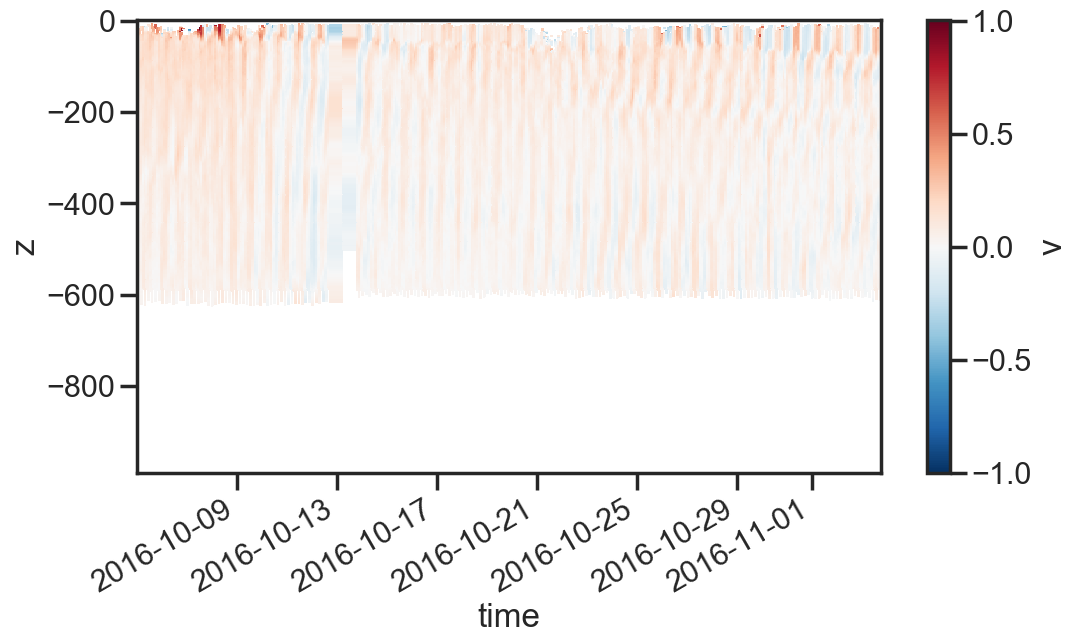

In [43]:
met.v.plot()

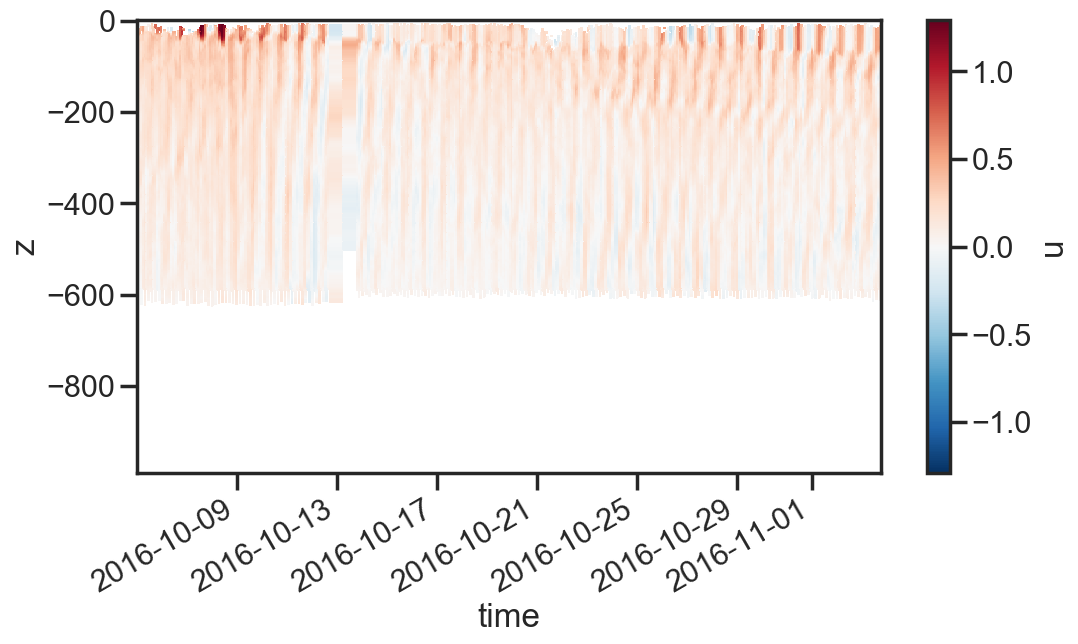

In [42]:
met.u.plot()

(-200, 0)

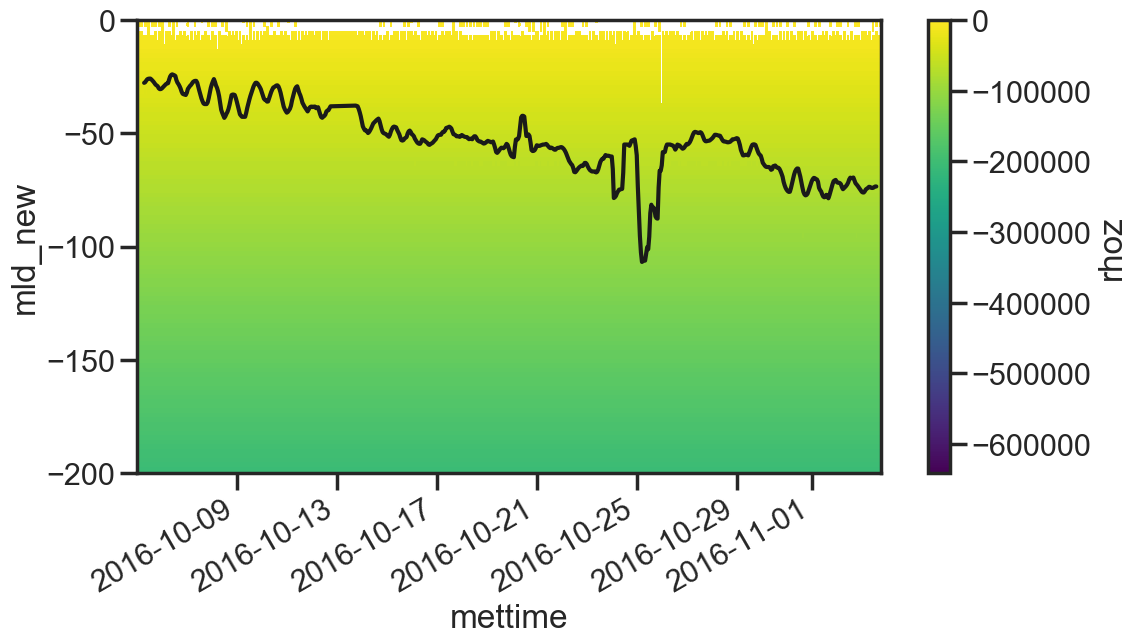

In [37]:
met.rhoz.plot()
met.mld_new.plot(color='k')
plt.ylim(-200,0)

### Match APE and forcing terms to find mixed layer depth

In [18]:
def find_ml_depth(t):
    print(t)
    absolute_error=1e6
    zml = -50
    niter = 0
    
    n2z = met.n2z.isel(mettime=t)
    B0 = met.B.isel(mettime=slice(None,t))
    
    while (absolute_error>0.1) and (niter<1000):
        A = n2z.where(metselect.z > zml).dropna('z').integrate('z')
        B = B0.dropna('mettime').integrate('mettime', datetime_unit='s')
        
        absolute_error = np.abs( A-B )
        
        if A>B:
            zml += .2
        elif B>A:
            zml -= .2
        else:
            break
        niter +=1
        
    return zml

In [19]:
mldepths = [find_ml_depth(t) for t in range(10,len(met.mettime))]

10


NameError: name 'metselect' is not defined

In [ ]:
from scipy.optimize import minimize

In [ ]:
len( mldepths) 

In [ ]:
# met.n2z.plot()
# plt.ylim(-300,0)
plt.plot(mldepths)

$$
PE = -g \int_{z_{ML}}^0 \rho (z)z dz
$$